## Importing Packages and Dataset

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

## Excess Return, Cumulative Return Factor and Log Returns

In [59]:
df_1926_2024 = pd.read_excel('../barnstable_analysis_data.xlsx', sheet_name='data',index_col=0)
df_1926_2024['SPX_t'] = df_1926_2024['SPX'] - df_1926_2024['TB1M'] 
df_1926_2024['log_SPX'] = np.log(df_1926_2024['SPX']+1)
df_1926_2024['log_TB1M'] = np.log(df_1926_2024['TB1M']+1)
df_1926_2024['log_SPX_t'] = np.log(df_1926_2024['SPX_t']+1)

df_1965_1999 = df_1926_2024[(df_1926_2024.index >= '1965-01-01') & (df_1926_2024.index <= '1999-12-31')]
df_2000_2024 = df_1926_2024[(df_1926_2024.index >= '2000-01-01') & (df_1926_2024.index <= '2024-12-31')]
df_1965_2024 = df_1926_2024[(df_1926_2024.index >= '1965-01-01') & (df_1926_2024.index <= '2024-12-31')]



def compute_stats(df, cols):
    return pd.DataFrame({
        'mean': df[cols].mean() * 12,
        'vol': df[cols].std() *np.sqrt(12),
    })

cols_levels = ['SPX', 'SPX_t', 'TB1M']
cols_logs = ['log_SPX', 'log_SPX_t', 'log_TB1M']

stats_1965_1999 = compute_stats(df_1965_1999, cols_levels + cols_logs)
stats_2000_2024 = compute_stats(df_2000_2024, cols_levels + cols_logs)
stats_1926_2024 = compute_stats(df_1926_2024, cols_levels + cols_logs)

final_table = pd.concat(
    [
        stats_1965_1999.add_suffix('_1965_1999'),
        stats_2000_2024.add_suffix('_2000_2024'),
        stats_1926_2024.add_suffix('_1926_2024')
    ],
    axis=1
)

index_labels = [
    ('levels', 'r^m (SPX)'),
    ('levels', 'r̃^m (SPX_t)'),
    ('levels', 'r^f (TB1M)'),
    ('logs', 'r^m (log_SPX)'),
    ('logs', 'r̃^m (log_SPX_t)'),
    ('logs', 'r^f (log_TB1M)')
]

final_table.index = pd.MultiIndex.from_tuples(index_labels, names=['category', 'variable'])

final_table = final_table.round(4)
final_table

mean_1965_1999  vol_1965_1999  mean_2000_2024  \
category variable                                                          
levels   r^m (SPX)                 0.1294         0.1494          0.0875   
         r̃^m (SPX_t)              0.0687         0.1502          0.0701   
         r^f (TB1M)                0.0615         0.0072          0.0175   
logs     r^m (log_SPX)             0.1176         0.1496          0.0756   
         r̃^m (log_SPX_t)          0.0572         0.1512          0.0581   
         r^f (log_TB1M)            0.0613         0.0071          0.0174   

                           vol_2000_2024  mean_1926_2024  vol_1926_2024  
category variable                                                        
levels   r^m (SPX)                0.1528          0.1155         0.1866  
         r̃^m (SPX_t)             0.1531          0.0833         0.1873  
         r^f (TB1M)               0.0056          0.0319         0.0085  
logs     r^m (log_SPX)            0.1538          0.0978         0.1859  
         r̃^m (log_SPX_t)         0.1542          0.0657         0.1869  
         r^f (log_TB1M)           0.0055          0.0318         0.0085

#### Subsample 1 (1965 - 1999) shows a higher return than Subsample 2 (2000 - 2024). This may be due to market downturns during the dot-com crash and the financial crisis. Log returns are lower than level returns, and the difference is more pronounced in periods of higher volatility.

## 2. Probability of Underperformance

In [61]:
sharpe_log_excess_65_99 = (stats_1965_1999.loc['log_SPX_t']['mean'] / stats_1965_1999.loc['log_SPX_t']['vol'])

In [65]:
underperformance_subsample1 = norm.cdf((sharpe_log_excess_65_99))
underperformance_subsample1_whole = norm.cdf(-np.sqrt(34) * (sharpe_log_excess_65_99))
underperformance_subsample1_15 = norm.cdf(-np.sqrt(15) * (sharpe_log_excess_65_99))
underperformance_subsample1_30 = norm.cdf(-np.sqrt(30) * (sharpe_log_excess_65_99))

pd.DataFrame({
    'Sharpe Ratio': [sharpe_log_excess_65_99],
    'Underperformance for any year': [underperformance_subsample1],
    'Underperformance for whole subsample': [underperformance_subsample1_whole],
    'Underperformance (15 years)': [underperformance_subsample1_15],
    'Underperformance (30 years)': [underperformance_subsample1_30]
}, index=['Subsample 1'])

,Sharpe Ratio,Underperformance for any year,Underperformance for whole subsample,Underperformance (15 years),Underperformance (30 years)
Subsample 1,0.378033,0.647297,0.013752,0.071581,0.019199


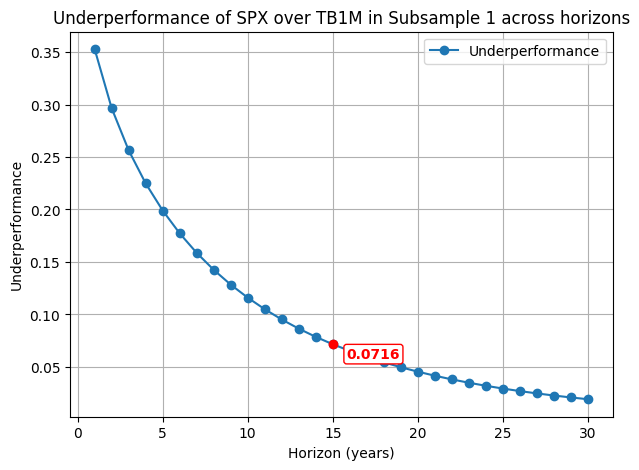

In [89]:
# Plot underperformance for Subsample 1 across horizons
horizons = np.arange(1, 31)
underperformance = norm.cdf(-np.sqrt(horizons) * (sharpe_log_excess_65_99))

plt.figure(figsize=(7, 5))
plt.title('Underperformance of SPX over TB1M in Subsample 1 across horizons')
plt.plot(horizons, underperformance, marker='o', label='Underperformance')  # Added markers
plt.xlabel('Horizon (years)')
plt.ylabel('Underperformance')
plt.legend()
plt.grid(True)  # Add grid lines

# Add value at 15 years
h_15_idx = 14  # 0-based index for year 15
plt.scatter(horizons[h_15_idx], underperformance[h_15_idx], color='red', zorder=5)
plt.annotate(f"{underperformance[h_15_idx]:.4f}",
             (horizons[h_15_idx], underperformance[h_15_idx]),
             textcoords="offset points",
             xytext=(10,-10),
             ha='left',
             fontsize=10,
             color='red',
             fontweight='bold',
             bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2'))
plt.show()

## 3. Full Sample Analysis

In [ ]:
stats_1965_2024 = compute_stats(df_1965_2024, cols_levels + cols_logs)
sharpe_log_excess_65_24 = (stats_1965_2024.loc['log_SPX_t']['mean'] / stats_1965_2024.loc['log_SPX_t']['vol'])
underperformance_30yr_1965_2024 = norm.cdf(-np.sqrt(30) * (sharpe_log_excess_65_24))
underperformance_30yr_1965_2024

0.019248146171371022

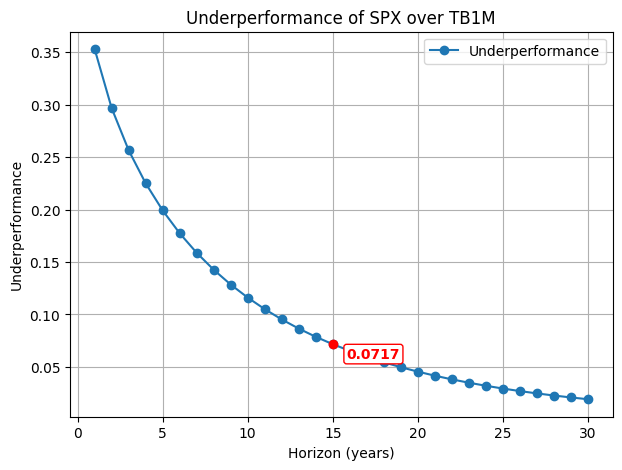

In [88]:
# Plot underperformance
horizons = np.arange(1, 31)
underperformance = norm.cdf(-np.sqrt(horizons) * (sharpe_log_excess_65_24))

plt.figure(figsize=(7, 5))
plt.title('Underperformance of SPX over TB1M')
plt.plot(horizons, underperformance, marker='o', label='Underperformance')
plt.xlabel('Horizon (years)')
plt.ylabel('Underperformance')
plt.legend()
plt.grid(True)

# Add value at 15 years
h_15_idx = 14  # 0-based index for year 15
plt.scatter(horizons[h_15_idx], underperformance[h_15_idx], color='red', zorder=5)
plt.annotate(f"{underperformance[h_15_idx]:.4f}",
             (horizons[h_15_idx], underperformance[h_15_idx]),
             textcoords="offset points",
             xytext=(10,-10),
             ha='left',
             fontsize=10,
             color='red',
             fontweight='bold',
             bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2'))
plt.show()

## In-Sample Estimate of Out-of-Sample Likelihood

In [85]:
std_insample_1965_1999 = stats_1965_1999.loc['log_SPX_t']['vol']
mean_insample_1965_1999 = stats_1965_1999.loc['log_SPX_t']['mean']
mean_outofsample_2000_2024 = stats_2000_2024.loc['log_SPX_t']['mean']

norm.cdf(-np.sqrt(30) * ((mean_outofsample_2000_2024 - mean_insample_1965_1999 )/ std_insample_1965_1999))

0.4858132441101697

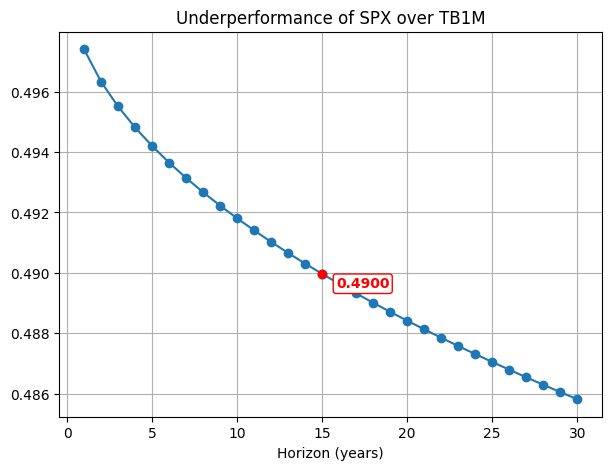

In [90]:
horizons = np.arange(1, 31)
underperformance = norm.cdf(-np.sqrt(horizons) * ((mean_outofsample_2000_2024 - mean_insample_1965_1999 )/ std_insample_1965_1999))

plt.figure(figsize=(7, 5))
plt.title('Underperformance of SPX over TB1M')
plt.plot(horizons, underperformance, marker='o', label='Underperformance')
plt.xlabel('Horizon (years)')
plt.grid(True)

# Add value at 15 years
h_15_idx = 14  # 0-based index for year 15
plt.scatter(horizons[h_15_idx], underperformance[h_15_idx], color='red', zorder=5)
plt.annotate(f"{underperformance[h_15_idx]:.4f}",
             (horizons[h_15_idx], underperformance[h_15_idx]),
             textcoords="offset points",
             xytext=(10,-10),
             ha='left',
             fontsize=10,
             color='red',
             fontweight='bold',
             bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2'))
plt.show()